## Model Training
### 1.1 Import data and required packages
Importing Pandas, Numpy, Matplotlib, Seaborn and Warning Library.

In [620]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import re
# Modelling
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import warnings

### Import the CSV Data as Pandas DataFrame

In [621]:
df = pd.read_csv('data/laptop_price.csv')

### Drop unnecessary column (laptop_ID)

In [622]:
df = df.drop(columns=['laptop_ID'],axis=1)
df.head()

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


### Check for Duplicated records and drop them

In [623]:
df = df.drop_duplicates()
df.duplicated().sum()

0

### Extract Cpu into 4 parts (manufacturer, series, model, clock speed), screen resolution, and convert memory to GB
* Intel Core i5 2,3GHz into (Intel Core, 5, 2.3)
* IPS Panel Retina Display 2560x1600 to just 2560x1600
* 1TB -> 1024 and 1GB to 1

In [624]:
# Function to extract the CPU manufacturer (first word of the string)
def extract_cpu_manufacturer(cpu):
    return cpu.split()[0]

# Function to extract the CPU series (first two words of the string)
def extract_cpu_series(cpu):
    return " ".join(cpu.split()[:2])

# Function to extract the CPU model
def extract_cpu_model(cpu):
    match = re.search(r'\d+[A-Za-z]*', cpu)
    return match.group() if match else None

# Function to extract the CPU clock speed (e.g., 2.3GHz as 2.3)
def extract_clock_speed(cpu):
    match = re.search(r'[\d\.]+GHz', cpu)
    return float(match.group()[:-3]) if match else None  # Remove the last 3 letters (GHz) and Converts to float

# Extract the screen resolution
def extract_screen_resolution(screen_res):
    match = re.search(r'\b\d+x\d+\b', screen_res)
    return match.group() if match else None

# Convert all capacity to GB
def convert_to_gb(value):
    if 'TB' in value:
        return float(value.replace('TB', '').strip()) * 1024  
    elif 'GB' in value:
        return float(value.replace('GB', '').strip())
    else:
        return None

### Apply the function into Cpu columns, ScreenResolution and Ram

In [625]:
# Split Cpu into 4 different columns
df['CPU Manufacturer'] = df['Cpu'].apply(extract_cpu_manufacturer)
df['CPU Series'] = df['Cpu'].apply(extract_cpu_series)
df['CPU Model'] = df['Cpu'].apply(extract_cpu_model)
df['CPU Clock Speed'] = df['Cpu'].apply(extract_clock_speed)


In [626]:
# Extract Resolution value from screenresolution
df['ResolutionValue'] = df['ScreenResolution'].apply(extract_screen_resolution)

In [627]:
# Convert RAM to Int
df['Ram'] = df['Ram'].str.replace('GB','').astype(int)

### Divided Memory into 2 parts (Capacity and MemoryType)

In [628]:
# Split Memory into 2 parts Capacity and Memory type
df['Capacity'] = df['Memory'].str.extract(r'(\d+(?:\.\d+)?\s?\w+)')
df['MemoryType'] = df['Memory'].str.extract(r'(SSD|HDD|Flash Storage|Hybrid)', expand=False)

In [629]:
# Convert Weight to Float
df['Weight'] = df['Weight'].str.replace('kg','').astype(float)

In [630]:
# Combine Company, TypeName and Product as one Column
df['Laptop'] = df['Company'] + df['TypeName'] + df['Product']

In [631]:
# Convert Resolution Value to Width and Height
df[['Width', 'Height']] = df['ResolutionValue'].str.split('x', expand=True).astype(int)

In [632]:
# delete unnecessary column
del_cols = ['Company', 'Product', 'TypeName', 'ScreenResolution', 'ResolutionValue', 'Cpu', 'Memory']
df = df.drop(columns=del_cols)

In [633]:
df.head()

,Inches,Ram,Gpu,OpSys,Weight,Price_euros,CPU Manufacturer,CPU Series,CPU Model,CPU Clock Speed,Capacity,MemoryType,Laptop,Width,Height
0,13.3,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,Intel,Intel Core,5,2.3,128GB,SSD,AppleUltrabookMacBook Pro,2560,1600
1,13.3,8,Intel HD Graphics 6000,macOS,1.34,898.94,Intel,Intel Core,5,1.8,128GB,Flash Storage,AppleUltrabookMacbook Air,1440,900
2,15.6,8,Intel HD Graphics 620,No OS,1.86,575.00,Intel,Intel Core,5,2.5,256GB,SSD,HPNotebook250 G6,1920,1080
3,15.4,16,AMD Radeon Pro 455,macOS,1.83,2537.45,Intel,Intel Core,7,2.7,512GB,SSD,AppleUltrabookMacBook Pro,2880,1800
4,13.3,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,Intel,Intel Core,5,3.1,256GB,SSD,AppleUltrabookMacBook Pro,2560,1600


### Preparing X and Y variables

In [634]:
X = df.drop(columns=['Price_euros'], axis=1)

In [635]:
X.head()

,Inches,Ram,Gpu,OpSys,Weight,CPU Manufacturer,CPU Series,CPU Model,CPU Clock Speed,Capacity,MemoryType,Laptop,Width,Height
0,13.3,8,Intel Iris Plus Graphics 640,macOS,1.37,Intel,Intel Core,5,2.3,128GB,SSD,AppleUltrabookMacBook Pro,2560,1600
1,13.3,8,Intel HD Graphics 6000,macOS,1.34,Intel,Intel Core,5,1.8,128GB,Flash Storage,AppleUltrabookMacbook Air,1440,900
2,15.6,8,Intel HD Graphics 620,No OS,1.86,Intel,Intel Core,5,2.5,256GB,SSD,HPNotebook250 G6,1920,1080
3,15.4,16,AMD Radeon Pro 455,macOS,1.83,Intel,Intel Core,7,2.7,512GB,SSD,AppleUltrabookMacBook Pro,2880,1800
4,13.3,8,Intel Iris Plus Graphics 650,macOS,1.37,Intel,Intel Core,5,3.1,256GB,SSD,AppleUltrabookMacBook Pro,2560,1600


In [636]:
y = df['Price_euros']

In [637]:
y

0       1339.69
1        898.94
2        575.00
3       2537.45
4       1803.60
         ...   
1270     638.00
1271    1499.00
1272     229.00
1273     764.00
1274     369.00
Name: Price_euros, Length: 1275, dtype: float64

In [638]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1275 entries, 0 to 1274
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Inches            1275 non-null   float64
 1   Ram               1275 non-null   int32  
 2   Gpu               1275 non-null   object 
 3   OpSys             1275 non-null   object 
 4   Weight            1275 non-null   float64
 5   Price_euros       1275 non-null   float64
 6   CPU Manufacturer  1275 non-null   object 
 7   CPU Series        1275 non-null   object 
 8   CPU Model         1275 non-null   object 
 9   CPU Clock Speed   1275 non-null   float64
 10  Capacity          1275 non-null   object 
 11  MemoryType        1275 non-null   object 
 12  Laptop            1275 non-null   object 
 13  Width             1275 non-null   int32  
 14  Height            1275 non-null   int32  
dtypes: float64(4), int32(3), object(8)
memory usage: 144.4+ KB


In [639]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
         ("StandardScaler", numeric_transformer, num_features),        
    ]
)

In [640]:
X = preprocessor.fit_transform(X)

In [641]:
X.shape

(1275, 858)

In [642]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,random_state=42)
X_train.shape, X_test.shape

((1147, 858), (128, 858))

### Create an Evaluate Function to give all metrics after model training

In [643]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [644]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]
rmse_list = []
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    rmse_list.append(model_test_rmse)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 100.3122
- Mean Absolute Error: 49.7209
- R2 Score: 0.9794
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1677.1976
- Mean Absolute Error: 493.8873
- R2 Score: -4.5354




Lasso
Model performance for Training set
- Root Mean Squared Error: 266.3061
- Mean Absolute Error: 197.6497
- R2 Score: 0.8549
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 263.6437
- Mean Absolute Error: 196.5218
- R2 Score: 0.8632


Ridge
Model performance for Training set
- Root Mean Squared Error: 160.5791
- Mean Absolute Error: 115.6706
- R2 Score: 0.9472
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 240.2072
- Mean Absolute Error: 166.6612
- R2 Score: 0.8865


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 246.3338
- Mean Absolute Error: 155.4878
- R2 Score: 0.8758
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 288.1715
- Mean Absolute Error: 175.0845
- R2 Score: 0.8366


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 21.4571
- Mean Absolute Error: 3.1699
- R2 Score: 0.9991
--

### Result

In [645]:
pd.DataFrame(list(zip(model_list, r2_list, rmse_list)), columns=['Model Name', 'R2_Score', 'RMSE']).sort_values(by=["R2_Score"],ascending=False)

,Model Name,R2_Score,RMSE
6,XGBRegressor,0.917109,205.239864
2,Ridge,0.886459,240.207180
5,Random Forest Regressor,0.883739,243.067144
1,Lasso,0.863222,263.643735
4,Decision Tree,0.847620,278.274281
3,K-Neighbors Regressor,0.836588,288.171495
7,AdaBoost Regressor,0.671720,408.442951
0,Linear Regression,-4.535420,1677.197614


### XGBoost Regression

In [646]:
xgb_model = XGBRegressor()
xgb_model = xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print(" Accuracy of the model is %.2f" %score)

 Accuracy of the model is 91.71


### Plot y_pred and y_test

Text(0, 0.5, 'Predicted')

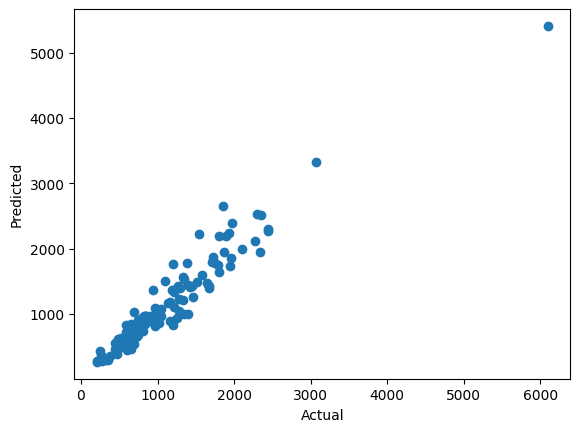

In [647]:
plt.scatter(y_test,y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')

<Axes: xlabel='Price_euros'>

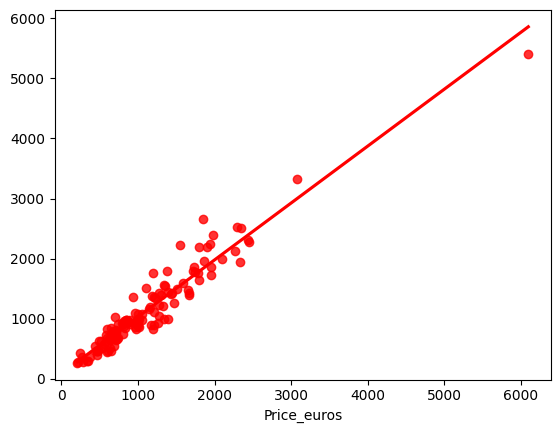

In [648]:
sns.regplot(x=y_test,y=y_pred,ci=None,color ='red')

### Difference between Actual and Predicted Values

In [649]:
pred_df=pd.DataFrame({'Actual Value':y_test,'Predicted Value':y_pred,'Difference':y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
1179,650.00,752.759399,-102.759399
342,716.00,788.396362,-72.396362
649,1584.00,1593.252319,-9.252319
772,1020.00,864.181152,155.818848
803,1749.00,1782.188110,-33.188110
...,...,...,...
296,979.00,918.323486,60.676514
987,1189.00,1369.930908,-180.930908
741,665.00,723.815979,-58.815979
712,726.00,666.597839,59.402161
